<a href="https://colab.research.google.com/github/GerardAlba/UdAAnaliticaFinancera/blob/main/UdAHierarchicalRiskParity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='0'></a>
# 1. Definició del problema

L'objectiu en aquest cas d'estudi és maximitxar la rendibilitat ajustada al risc, utilitzant un algorisme de clustering amb un dataset d'accions, per ponderar el capital en cada actiu diferent.

<a id='1'></a>
# 2. Obtenim les dades i llibreries de Python

<a id='1.1'></a>
## 2.1. Importem les llibreries bàsiques i d'optimització

In [136]:
# Importem les llibreries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import pandas_datareader as dr
import matplotlib.ticker as ticker

In [137]:
# Importem les llibreries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

# Importem els paquets i llibreries pel model de clustering HCA-HRP
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

# Paquet d'optimització mitjana-variància (Markowitz)
import cvxopt as opt
from cvxopt import blas, solvers


Verifiquem que el paquet cvxopt està instal.lat

In [138]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
if 'cvxopt' not in installedPackages :
    !pip install cvxopt==1.2.5

<a id='1.2'></a>
## 2.2. Obtenim el dataset

Les dades històriques de les accions que formen l'univers per l'exemple són les de l'S&P500. Podeu utilitzar el codi al repositori del curs per descarregar en un fitxer csv el període escollit. Aquí, hem carregat el dataset (S&P500-cleaned_prices.csv) a l'entorn Colab d'aquest projecte.

In [139]:
# Carreguem el dataset
#dataset = read_csv('SP500Data.csv',index_col=0)
dataset = read_csv('S&P500-cleaned_prices.csv',index_col=0)

In [114]:
import warnings
warnings.filterwarnings('ignore')

In [140]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Anàlisi Exploratòria de Dades (EDA)

<a id='2.1'></a>
## 3.1. Estadístiques de les dades

In [141]:
# shape
dataset.shape

(1151, 492)

In [142]:
# Ullada a les dades
set_option('display.width', 100)
dataset.head(5)

,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,83.347351,28.982893,72.876114,72.841957,80.065536,43.400002,196.058426,334.429993,110.811874,41.041607,...,191.783920,24.695112,140.598862,54.467464,56.539852,75.651711,94.008148,139.936569,259.140015,129.515060
2020-01-03,82.009132,27.548195,72.167610,72.150543,79.089470,43.349998,195.731842,331.809998,108.861168,40.961498,...,191.830902,24.737123,138.513351,54.729412,56.085312,76.096985,93.713684,139.570740,256.049988,129.534378
2020-01-06,82.251556,27.219410,72.742653,72.719948,79.503822,43.520000,194.453735,333.709991,107.582207,40.641071,...,192.065567,24.686710,138.239212,54.650837,56.515938,75.604317,93.658501,138.764206,258.010010,128.539902
2020-01-07,82.503685,27.119778,72.400551,72.305115,79.061821,43.160000,190.255447,333.390015,110.029755,40.151520,...,191.671265,24.527061,138.895218,54.537319,56.053417,75.320107,93.824112,138.642227,256.470001,128.974380
2020-01-08,83.318245,27.737495,73.565193,72.817551,79.384117,42.730000,190.628662,337.869995,111.023499,39.706486,...,191.887192,24.619490,139.766602,54.484932,55.208103,75.575905,93.989746,140.302338,247.639999,128.694382


<a id='3'></a>
## 4. Preparació de les dades

<a id='3.1'></a>
## 4.1. Depuració i preparació de dades


In [118]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = False


(1151, 492)

Eliminem columnes que tinguin més d'un 30% de valors buits

In [143]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(1151, 492)

In [144]:
# Fill the missing values with the last value available in the dataset.
dataset=dataset.fillna(method='ffill')
dataset.head(2)

,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,83.347351,28.982893,72.876114,72.841957,80.065536,43.400002,196.058426,334.429993,110.811874,41.041607,...,191.783920,24.695112,140.598862,54.467464,56.539852,75.651711,94.008148,139.936569,259.140015,129.515060
2020-01-03,82.009132,27.548195,72.167610,72.150543,79.089470,43.349998,195.731842,331.809998,108.861168,40.961498,...,191.830902,24.737123,138.513351,54.729412,56.085312,76.096985,93.713684,139.570740,256.049988,129.534378


<a id='3.2'></a>
## 4.2. Pre-Processat de les dades

Dividim les dades per l'entrenament del model: entre train i test.
Transformem els preus en retorns (variacions porcentuals)

In [121]:
X= dataset.copy('deep')
row= len(X)
train_len = int(row*.8)

In [145]:
X_train = X.head(train_len)
X_test = X.tail(row-train_len)

In [146]:
# Càlcul de les rendibilitats a partir dels preus
returns = X_train.pct_change().dropna()
returns_test=X_test.pct_change().dropna()

<a id='4'></a>
# 5. Algorismes i Model HRP

<a id='4.1'></a>
## 5.1. Hierarchical Clustering Analysis i Dendograma

Generem els cluster a partir de les correrlacions usant clustering jeràrquic aglomeratiu.

Linkage realitza el clustering i retorna la llista de clusters Z=[stock_1, stock_2, distance, sample_count]

#### Distància basada en correlacions

In [147]:
def correlDist(corr):
    # Matriu de distàncies: 0<=d[i,j]<=1
    dist = ((1 - corr) / 2.)**.5
    return dist

In [148]:
#Calula linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([2.04000000e+02, 2.05000000e+02, 8.19083729e-02, 2.00000000e+00])

Grafiquem l'arbre de clusters (dendograma). Les fulles de l'arbre són les accions individuals, i l'arrel és el cluster superior. La mesura de distància entre els clusters correspon a l'eix *y* (si les branques són llargues, implica més diversificació entre clusters corresponents)

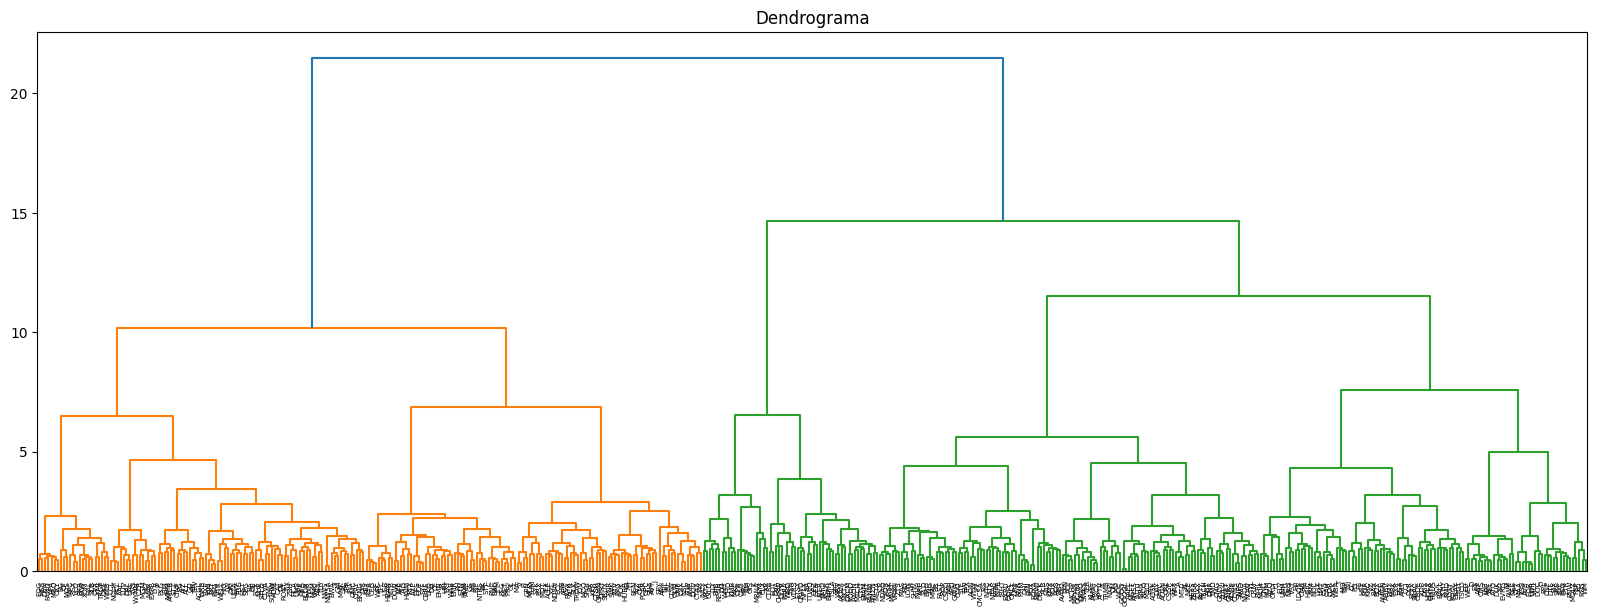

In [150]:
# Dendograma
plt.figure(figsize=(20, 7))
plt.title("Dendrograma")
dendrogram(link,labels = X.columns)
plt.show()

<a id='4.2'></a>
## 5.2 Mètode Hierarchial Risk Parity

#### Quasi-diagonal i pesos Hierarchial Risk Parity

'quasi-diagonalitació': agrupem inversions similars a la matriu de covariàncies re-ordenada. Facilita l'assignació dels pesos (inversos a la variància)

In [127]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        # Codi original modificat: uso ._append enlloc .append, que s'ha eliminat a pd 2.0
        sortIx = sortIx._append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

#### Bisecció recursiva

Veieu la teoria: assignem pesos de manera recursiva, segons la volatilitat de cada cluster

In [128]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

#### Comparem amb MVO Markowitz

Compararem amb el portfoli de mínima variància de Markowitz (mitjana-variància o MVO)

    1. MVP - Markowitz’s Minimum-Variance Portfolio
    2. HRP - Hierarchial Risk Parity

In [129]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)


    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

#### Obtenim els pesos de la cartera segons cada mètode

In [130]:
def get_all_portfolios(returns):

    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [131]:
portfolios = get_all_portfolios(returns)

Text(0.5, 1.0, 'HRP')

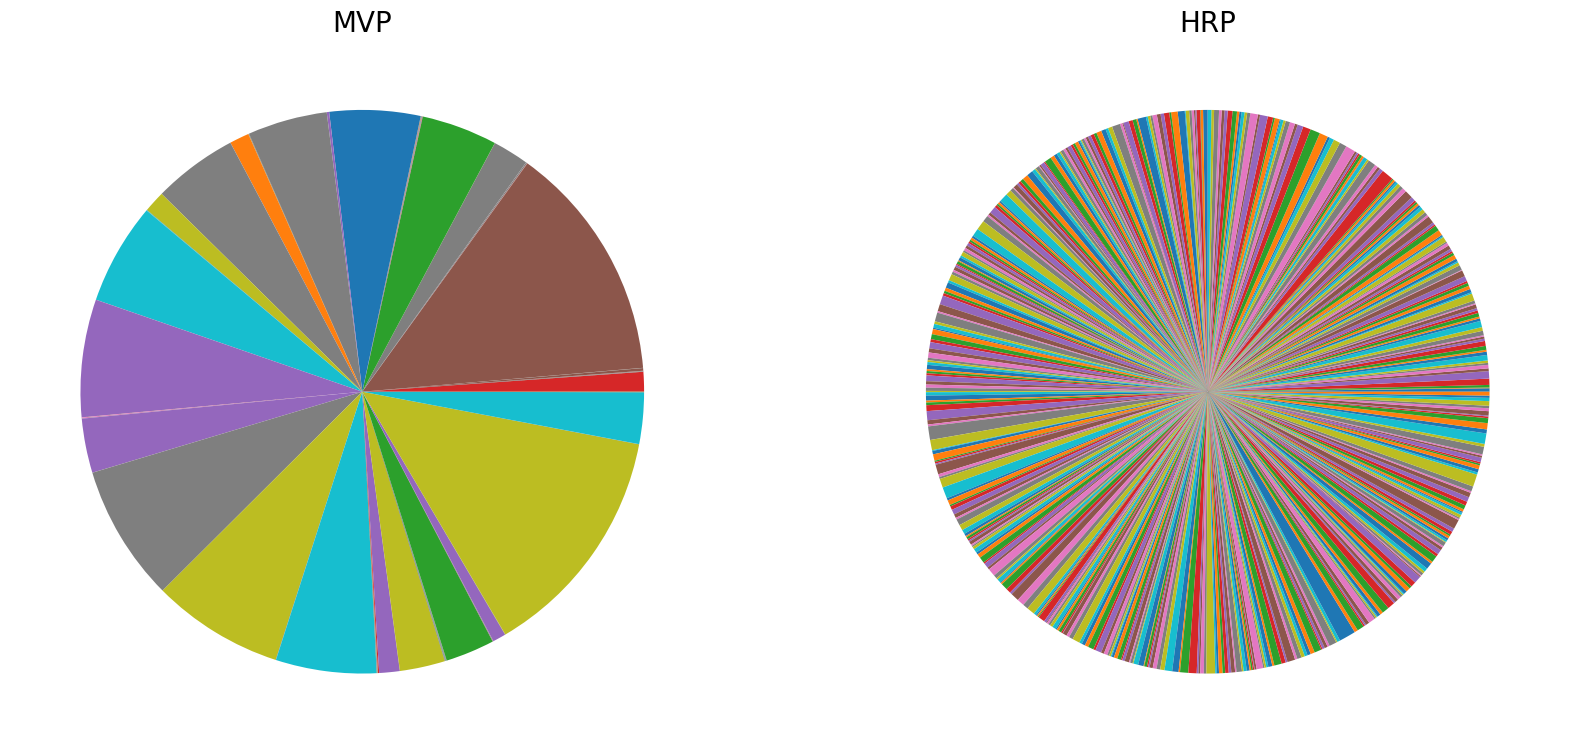

In [156]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
ax1.pie(portfolios.iloc[:,0], );
ax1.set_title('MVP',fontsize = 20)
ax2.pie(portfolios.iloc[:,1]);
ax2.set_title('HRP',fontsize = 20)
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

<a id='5'></a>
# 6. Backtest fora de la mostra. Usem dataset *test* enlloc de *train*


In [132]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

<Axes: title={'center': 'Resultats de test'}, xlabel='Date'>

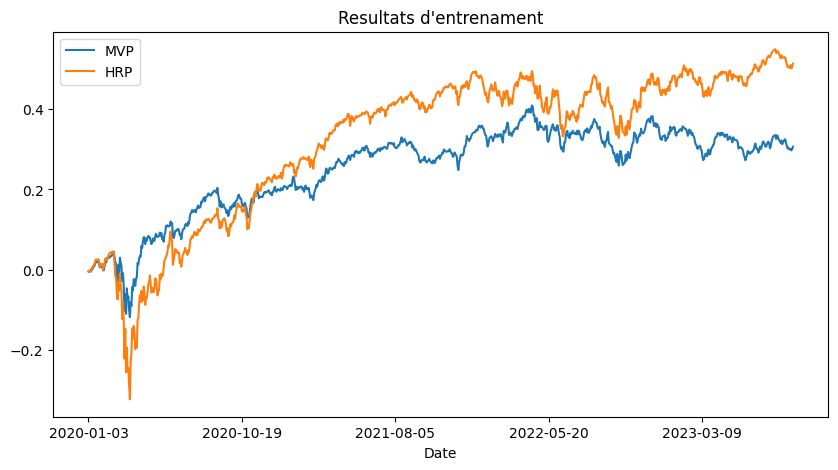

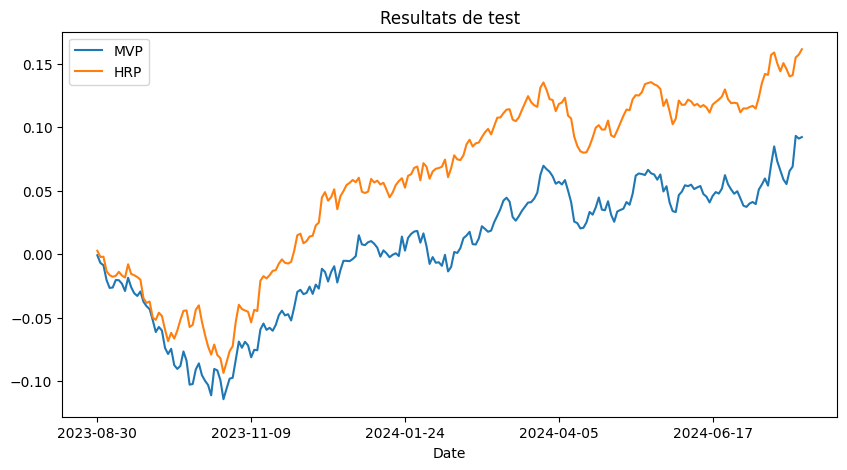

In [151]:
Insample_Result.cumsum().plot(figsize=(10, 5), title ="Resultats d'entrenament")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), title ="Resultats de test")

### Mètriques de risc-rendibilitat

In [157]:
# Mètriques en dataset train
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

,stdev,sharp_ratio
MVP,0.146121,0.574457
HRP,0.214428,0.655628


In [153]:
# Mètriques en dataset test
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

,stdev_oos,sharp_ratio_oos
MVP,0.113941,0.888151
HRP,0.105777,1.673160


Observem les millors mètriques del model HRP. La diversificació del risc d'HRP és una metodologia més robusta